# GLU GPT Experiment

## What is GLU?
$$
x \mapsto \bigl(\phi(xW_A + b_A)\bigr) \otimes (xW_B + b_B)\,W_O + b_O
$$


### Configure the machine and install packages


In [1]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout main && git pull
    !pip install tiktoken --quiet
    !pip uninstall -y tensorflow

fatal: destination path 'jaxpt' already exists and is not an empty directory.
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.


In [2]:
from pathlib import Path
import sys

if is_colab():
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )

sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/content/jaxpt/src


In [3]:
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np

os.environ['XLA_FLAGS'] = (
    '--xla_gpu_triton_gemm_any=True '
    '--xla_gpu_enable_latency_hiding_scheduler=true '
)

os.environ.update({
  "NCCL_LL128_BUFFSIZE": "-2",
  "NCCL_LL_BUFFSIZE": "-2",
  "NCCL_PROTO": "SIMPLE,LL,LL128",
 })


# Hardware setup
print("JAX version:", jax.__version__)
devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)

requested_device = "gpu"

jax.config.update("jax_platform_name", requested_device) # Make sure we're using the GPU

device = jax.default_backend()
if device != requested_device:
    warnings.warn(f"not using {requested_device}. Using {device}")
else:
    print(f"using {device}")


#####################################
##        jax.lax matmul presets   ##
#####################################
## 'ANY_F8_ANY_F8_F32',
## 'ANY_F8_ANY_F8_F32_FAST_ACCUM'
## 'ANY_F8_ANY_F8_ANY'
## 'ANY_F8_ANY_F8_ANY_FAST_ACCUM'
## 'F16_F16_F16'
## 'F16_F16_F32'
## 'BF16_BF16_BF16'
## 'BF16_BF16_F32'
## 'BF16_BF16_F32_X3'
## 'BF16_BF16_F32_X6'
## 'TF32_TF32_F32'
## 'TF32_TF32_F32_X3'
## 'F32_F32_F32'
## 'F64_F64_F64'
#####################################

jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
#os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

if device == "tpu":
    def list_tpu_memory():
        devices = jax.devices()
        for device in devices:
            if 'TPU' in str(device.device_kind):
                print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

    list_tpu_memory()

# Test the device
A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Makes sure the matmul is fast
%timeit (A@A).block_until_ready()

JAX version: 0.5.2
Available devices: 1
using gpu
822 µs ± 30.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Initialize the GPT-2 model and perform a sanity check

In [4]:
from functools import partial

import tiktoken
from flax import nnx

from jaxpt.infer import generate
from jaxpt.models import GLUGPT, GLUGPTConfig

"""
+--------------+---------+--------+------+
| Model        | Layers  | Heads  | Embd |
+--------------+---------+--------+------+
| gpt2-medium  | 24      | 16     | 1024 |
| gpt2-large   | 36      | 20     | 1280 |
| gpt2-xl      | 48      | 25     | 1600 |
+--------------+---------+--------+------+
"""

key = jax.random.PRNGKey(1337)
rngs = nnx.Rngs(key)
config = GLUGPTConfig(dtype=jnp.bfloat16, \
                   vocab_size=50304, \
                   sdpa_implementation="cudnn" if device=="gpu" else "xla")
nnx.display(config)
m = GLUGPT(config, rngs)
#m = load_checkpoint("run_20250311_uqdwjq", 5600)
graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
nnx.display(state)

def generate_completions(prefix="Hello, I'm a language model,"):
  m.eval()
  num_completions = 5
  max_length = 20
  generate_completion = partial(generate, m, max_length=max_length)
  enc = tiktoken.get_encoding('gpt2')
  tokens = enc.encode(prefix)
  tokens = jnp.array(tokens, dtype=jnp.int32)
  tokens = jnp.expand_dims(tokens, axis=0)
  x = jnp.tile(tokens, (num_completions, 1))


  x = generate_completion(x=x) # Make sure you can do a forward pass
  output = []
  for i in range(num_completions):
      tokens = x[i, :max_length].tolist()
      decoded = enc.decode(tokens)
      output.append(decoded)
  return output

#completions = generate_completions()
#for completion in completions:
#print(completion)


### Configure Training Run

In [11]:
from datetime import datetime
import random
import string


def generate_random_code(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

timestamp = datetime.now().strftime("%Y%m%d")
random_code = generate_random_code()
run_dir = f"run_{timestamp}_{random_code}"
print(run_dir)

if is_colab():
  output_dir = Path().absolute().parent
else:
  output_dir = Path("/home/ubuntu/gpt2-train") # Lambda Labs setup
  #output_dir = Path().absolute().parent # Local setup

checkpoint_dir =   output_dir / "checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Checkpoint directory: {checkpoint_dir}")

log_dir = output_dir / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
print(f"Log directory: {log_dir}")

def save_checkpoint(m, step):
  checkpoint_path = checkpoint_dir / run_dir / f"checkpoint-{step}.pt"
  m.save_checkpoint(checkpoint_path)

def load_checkpoint(model, run_dir, step):
  checkpoint_path = checkpoint_dir / run_dir / f"checkpoint-{step}.pt"
  m = model.load_checkpoint(checkpoint_path, rngs)
  return m

run_20250421_lvufee
Checkpoint directory: /checkpoints
Log directory: /logs


In [6]:
import dataclasses

import optax


############################
# Nvidia A100 (x 8) Config #
############################

@dataclasses.dataclass
class TrainerConfig:
  num_tokens_per_batch: int = 2**12 # 2**19, 0.5 million as per the GPT 3.5 paper
  mB: int = 32
  T: int = 128
  max_steps: int = 19073 # 1 epoch (99 shards of the dataset should be around 18883, but Karpathy used 19073 for some reason)
  max_lr: float = 6e-4
  min_lr: float = max_lr * 0.1
  max_grad_norm: float = 1.0  # Clip gradients to this norm
  warmup_steps: int = 715
  print_interval: int = 1
  eval_interval: int = 250
  checkpoint_interval: int = 250
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T * num_devices) # Number of steps over which to average the gradient


##############
# CPU Config #
##############

trconf = TrainerConfig()
'''
trconf = TrainerConfig(
  num_tokens_per_batch=2**14,
  mB=16,
  T=1024,
  max_steps=9*48, # 6 epoch(s)
  max_lr=6e-4,
  min_lr=6e-5,
  max_grad_norm=1.0,
  warmup_steps=10,
  print_interval=1,
  eval_interval=50,
  checkpoint_interval=0,

)
'''
trconf.grad_accumulation_steps =  trconf.num_tokens_per_batch // (trconf.mB * trconf.T * num_devices) # Number of steps over which to average the gradient

# Set up the optimizer
def warmup_with_cosine_decay_schedule(step):

    warmup_lr = trconf.max_lr * (step + 1) / trconf.warmup_steps
    coeff = 0.5 * (1 + jnp.cos(jnp.pi * (step - trconf.warmup_steps) / (trconf.max_steps - trconf.warmup_steps)))
    cosine_lr =  trconf.min_lr + coeff * (trconf.max_lr - trconf.min_lr)

    return jnp.where(step < trconf.warmup_steps,
                     warmup_lr,
                     jnp.where(step < trconf.max_steps, cosine_lr, trconf.min_lr))

# Generate a weight decay mask
# First split the model into params and variables
graphdef, params, variables = nnx.split(m, nnx.Param, nnx.Variable)
# Then create a mask for the weight decay params
weight_decay_mask = jax.tree_util.tree_map(lambda x: len(x.shape) > 1, params)


tx = optax.chain(
    optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adamw(warmup_with_cosine_decay_schedule, b1=0.9, b2=0.95, weight_decay=0.1, mask=weight_decay_mask)
)
optimizer = nnx.Optimizer(m, tx)

# count the number of weight decay params
def f(x, y):
    if x:
        return y.size
    return 0

weight_decay_params = jax.tree_util.tree_map(f, weight_decay_mask, params)
weight_decay_param_count = jax.tree_util.tree_reduce(lambda x, y: x + y, weight_decay_params, 0)


print(f"weight decay param count: {weight_decay_param_count:,}")
print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"sub-batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB)
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB * num_devices}")
print(f"max steps: {trconf.max_steps}")


weight decay param count: 152,666,112
tokens/batch: 4,096
block size: 128
sub-batch size: 32
no. gradient accumulation steps: 1
effective batch size per device:  32
effective batch size: 32
max steps: 19073


### DataLoader and Validation Setup



In [7]:
from jaxpt.dataloaders import DataLoader
from jaxpt.train import loss_fn

dataset = "panchatantra-ryder"

if is_colab():
    dataset_path = Path().absolute() / "jaxpt" / "datasets" / dataset / "processed"
else:
    if dataset == "fineweb-edu":
      dataset_path = "/home/ubuntu/gpt2-train/fineweb-edu/processed"
    elif dataset == "panchatantra-ryder":
      dataset_path = Path().absolute().parent / "src"/ "jaxpt" / "datasets" / dataset / "processed"
    else:
      raise ValueError(f"Dataset {dataset} not found")

train_dl = DataLoader(dirpath=dataset_path, batch_size=trconf.mB, block_size=trconf.T, device_rank=num_devices, label="train")
eval_dl = DataLoader(dirpath=dataset_path, batch_size=trconf.mB, block_size=trconf.T, device_rank=1, label="valid", quiet=True)

def validate(m):
  valid_loss = 0.0
  eval_steps = 10
  for i in range(eval_steps):
    batch, targets = eval_dl()
    batch = np.squeeze(batch)
    targets = np.squeeze(targets)
    loss = loss_fn(m, batch, targets)
    valid_loss += loss
  valid_loss /= eval_steps
  return valid_loss

def evaluate(m):
  m.eval()
  completions = generate_completions()
  val_loss = validate(m)
  m.train()
  return val_loss, completions



dataloader initialized:
------------------------
label:          train
shards:         1
shard size:     146,776
batch size:     32
block size:     128
device rank:    1
------------------------


### Let's train the model

valid loss: 5.0938
Hello, I'm a language model, nothing before of water he on They then, I had
Hello, I'm a language model, then give sightous death on if his body will such but
Hello, I'm a language model, he but you him to tell your heart you . Your
Hello, I'm a language model, my path your-dcleot upon to go at nothing
Hello, I'm a language model, you were ready-apple To friend my plan that his
valid loss: 5.6562
Hello, I'm a language model, being;jightses?" and Gar anointing!'
Hello, I'm a language model, at me under his people is just one orANT-drawn
Hello, I'm a language model, without out today and- For many frogs on every You was
Hello, I'm a language model, most like nased after because its any without reptyped
Hello, I'm a language model, comacr to. For another own was darteduly


valid loss: 6.4062
Hello, I'm a language model, because noted on here as what . an !" relatives
Hello, I'm a language model, Who does ani perceived me also or in ears are is
Hello, I'm a language model, is very rest he I had that you does Blike
Hello, I'm a language model, since you was Ilinges can get when Please to us
Hello, I'm a language model, too off delighted by her  Shheart was rose, though


valid loss: 6.8125
Hello, I'm a language model, your re sight the birth: you? He should you bl
Hello, I'm a language model, people," man at such a's nest's sake onMy
Hello, I'm a language model,. First, where I woman," would be  no little
Hello, I'm a language model, since Soft too of our dear person does me We?"
Hello, I'm a language model, how an ceremony, waiting ich reply trouble here. Therefore


valid loss: 7.3438
Hello, I'm a language model, to any dispute their person a treasure very rest , 
Hello, I'm a language model, sir or not return) my fel or disturbing good ethics fellow
Hello, I'm a language model, since an upper dear friend has. a throat do to
Hello, I'm a language model, but bring; he n answers vain under being ready who.
Hello, I'm a language model, or laughing draw your treasure. Pr vulner (Aday does


valid loss: 7.4375
Hello, I'm a language model, troubleg destructionIn sugar save in thicklike-Mail away
Hello, I'm a language model, Why about others of merchants up on how strife the maxims
Hello, I'm a language model, and strife town against me in order yourself doom  bl terms
Hello, I'm a language model, since ruinuTake end eyesableices soul  ! More
Hello, I'm a language model, spirit usWell! dance  we time fulfilled fate's proportion


valid loss: 7.7500
Hello, I'm a language model, scornainAfterthreeationsb the occasions control -bottom
Hello, I'm a language model, nor eating spirits HeIf many joy for days grew find professors
Hello, I'm a language model, disturbingdly eating advantage when food forth milk on Gar inter
Hello, I'm a language model, woesout occasions shewood youSpot landM There sed herb
Hello, I'm a language model, ICrverniness for my works tonight indeed he Mountainfore


valid loss: 7.6875
Hello, I'm a language model, making greed greedan sentiments?Long herself," -Po
Hello, I'm a language model, mother yourn soul is your undertake does your sake spotster
Hello, I'm a language model, occasion?" But ? Rusty trouble hang away will. How when
Hello, I'm a language model, anBring selike»» myself properWhat S woman hang
Hello, I'm a language model, lesemb ? AsWhat  w princery* to listen


valid loss: 7.9062
Hello, I'm a language model, money none appeared — There to undertake swayIt sorrow for to
Hello, I'm a language model, Friend sway few made Cloud a natural soul woes ofWe minister
Hello, I'm a language model,har Cloud-old S innocence run. Please  issued from
Hello, I'm a language model, . office took depend find Aftersmithmine one going fail as
Hello, I'm a language model, others- That se lady idn shareweenight sent


valid loss: 7.7500
Hello, I'm a language model, That Flwn Supposelikeification if Theoport by  ret
Hello, I'm a language model, to how still troublearding over!' tool.' ThereFurthermore O
Hello, I'm a language model, saint or consequence trouble over out overdmon, but someone
Hello, I'm a language model, therehip *| how afarOnHowCitylikeoverty ?
Hello, I'm a language model, so betportastlesslyckhereSh oncearding overk


valid loss: 8.1250
Hello, I'm a language model, away were representations(mesitM virtue (iving aem
Hello, I'm a language model, weatheredakeyAfter once — There shows yourflyfly
Hello, I'm a language model, S weather. Well over danced to away Give  Let power
Hello, I'm a language model, our sky." reflection flee once There toolishedAfter milk what
Hello, I'm a language model, Oio burst; his plight M; en crocod  were


valid loss: 8.0625
Hello, I'm a language model,. Before were toAtWhose money If a crow for
Hello, I'm a language model, saint to enter delighted send bit man for some trouble man Give
Hello, I'm a language model, trouble daily.bowl by summer for delighted lifted the fellow 
Hello, I'm a language model, mother daily trade THE by giving disturbed tradeurn by night PAN
Hello, I'm a language model, or thereour.Ear  billSupp sendIN by Blossom


valid loss: 8.1250
Hello, I'm a language model, my vice PANated rice, and now though  of massive
Hello, I'm a language model, once king true light proper town waking M offering the inhabitants home
Hello, I'm a language model, hardHowday money and rolled-conductmly breasts,
Hello, I'm a language model, mother by inhabitants by going wifewhilearc commercial lightningil diet
Hello, I'm a language model, how can for deterOnkeysING govern native Straightitudespped


valid loss: 8.1250
Hello, I'm a language model, givingKEYastant bit O spotuta Straight  of Death
Hello, I'm a language model, damn except as bestid dry? jaws me the enter!
Hello, I'm a language model, someone HangEDentsATIONspeactority dream by Shiva bro
Hello, I'm a language model, bribery himATION danced strife perfume there spend because how dict parts
Hello, I'm a language model, deceit nights beforethem there  spendIGFEable seas ELE


Received KeyboardInterrupt. Exiting...
valid loss: 8.1250
completions: ["Hello, I'm a language model, howementsUMrived refuge won  OF vision; eightONG", "Hello, I'm a language model, Straight ! drove beforehand bent PANselors gives aged mistakeity", "Hello, I'm a language model, someone honey msageHide ?hend luxuryATION savUM", "Hello, I'm a language model, a refuge humiliation formed hereidinglect ANDiding,agonist grown", "Hello, I'm a language model, resolutionINGurn truthTHE  bill/amorow goingM"]
Hello, I'm a language model, howementsUMrived refuge won  OF vision; eightONG
Hello, I'm a language model, Straight ! drove beforehand bent PANselors gives aged mistakeity
Hello, I'm a language model, someone honey msageHide ?hend luxuryATION savUM
Hello, I'm a language model, a refuge humiliation formed hereidinglect ANDiding,agonist grown
Hello, I'm a language model, resolutionINGurn truthTHE  bill/amorow goingM


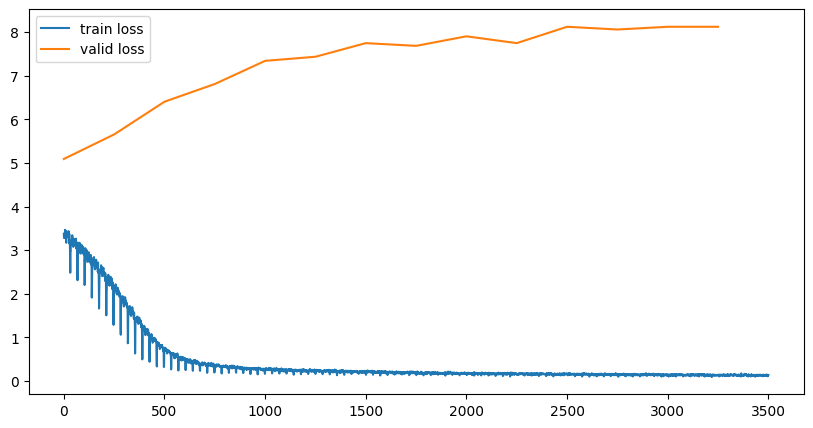

In [12]:
%matplotlib inline

import time
import logging
import warnings

import matplotlib.pyplot as plt

from jaxpt.utils import append_to_csv
from jaxpt.train import parallel_train_step


train_losses = []
val_losses = []
append_to_csv(log_dir / f"{run_dir}_train.csv", ["step", "lr", "loss", "norm", "time", "tokens_processed", "tokens_per_sec"])
append_to_csv(log_dir / f"{run_dir}_valid.csv", ["step", "loss"])

m.train()
try:
  for step in range(trconf.max_steps):
    start = time.time()
    batch, target = train_dl()
    avg_loss, avg_grads = parallel_train_step(m, optimizer, batch, target)
    avg_loss.block_until_ready()
    # compute stats
    avg_loss = jnp.float32(avg_loss[0])
    lr = warmup_with_cosine_decay_schedule(step)
    norm = 0 # norm[0]|
    iter_time = time.time() - start
    sub_step_time = iter_time / trconf.grad_accumulation_steps
    tokens_per_sec = num_devices * trconf.mB * trconf.T * trconf.grad_accumulation_steps / iter_time
    tokens_processed = (step+1) * num_devices * trconf.grad_accumulation_steps * trconf.mB * trconf.T

    if step % trconf.print_interval == 0:
      train_losses.append((step, avg_loss))
      append_to_csv(log_dir / f"{run_dir}_train.csv", [step, lr, avg_loss, norm, iter_time*1000, tokens_processed, tokens_per_sec])
      print(f"{step} | lr: {lr:0.2e} | loss: {avg_loss:0.4f} | norm: {norm:0.2f} | time: {iter_time*1000:0.2f}ms | tokens processed: {tokens_processed:,} | tok/sec: {tokens_per_sec:,.2f}", end="\r")
    if step % trconf.eval_interval == 0:
      valid_loss, completions = evaluate(m)
      valid_loss = jnp.float32(valid_loss)
      val_losses.append((step, valid_loss))
      append_to_csv(log_dir / f"{run_dir}_valid.csv", [step, valid_loss])
      print(f"valid loss: {valid_loss:0.4f}"  )
      for completion in completions:
        print(completion)
    if step > 0 and trconf.checkpoint_interval > 0 and step % trconf.checkpoint_interval == 0:
      save_checkpoint(m, step)


except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")

valid_loss, completions = evaluate(m)
valid_loss = jnp.float32(valid_loss)
print(f"valid loss: {valid_loss:0.4f}")
print(f"completions: {completions}")
for completion in completions:
  print(completion)
plt.figure(figsize=(10, 5))
plt.plot([x[0] for x in train_losses], [x[1] for x in train_losses], label="train loss")
plt.plot([x[0] for x in val_losses], [x[1] for x in val_losses], label="valid loss")
plt.legend()
plt.savefig(log_dir / f"{run_dir}.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()
